# Homework 3

This homework will explore linear regression and resampling techniques by analysing data from a database of glaciers. The database is *Glatilda* for [*Glacier Ice Thickness Database*](!https://www.gtn-g.ch/data_catalogue_glathida/).

1. Data prep (5 points)
2. Mapping (10 points)
3. Correlations between parameters (5 points)
4. Linear regression and resampling techniques (10 points)

## 1. Data Prep (5 points total)

### a) Download data (1 point) 
The database is saved on a GitLab repository that you may clone: https://gitlab.com/wgms/glathida.git



In [55]:
# answer - NTS: ! at start of line pushes the script segment to CLI, rather than Python kernel
!git clone https://gitlab.com/wgms/glathida.git HW3_Data/glathida

fatal: destination path 'HW3_Data/glathida' already exists and is not an empty directory.


### b) Import Python modules (1 point) 
Import pandas, geopandas, plotting, raster files,  numpy, netcdf

In [51]:
# solution
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio as rio
import numpy as np
import netCDF4 as cdf

### c) Read data (2 points)
Read the glacier data from the file ``glathida/data/glacier.csv`` into a pandas data frame, and decribe briefly the dataframe content and its first few lines.

In [57]:
# solution
t_path = "HW3_Data/glathida/data/glacier.csv"
df_glacier = pd.read_csv(t_path,index_col=[0])

# print(df_glacier)
print('Columns of glacier.csv are:')
# Use inline to iterate across alphabetically sorted column values
[print(x) for x in df_glacier.columns.sort_values()];

Columns of glacier.csv are:
area
date
external_db
external_id
flag
interpolation_method
latitude
length_profiles
longitude
max_date
max_thickness
max_thickness_uncertainty
mean_slope
mean_thickness
mean_thickness_uncertainty
name
number_points
number_profiles
remarks
survey_id


**Explore the data with visualization**
Before making any inference of models with the data, we will start by exploring basic correlations among parameters by plotting. In particular, we will focus on ``mean_thickness``, ``area``, ``mean_slope`` parameters.

### d) Remove bad data (1 point)

The database may contain Nans and other "bad" values (welcome to the data world!). First we will clean the data by removing nans. We are mostly interested in the thickness, area, and slope



In [88]:
#answer below 
# Create boolean index for union of rows with NaN entries in desired columns
NaNor_IND = (df_glacier['mean_thickness'].isna()) | (df_glacier['mean_slope'].isna()) | (df_glacier['area'].isna())
# Similarly, this could be done with an intersection of non-NaNs
INT_IND = (df_glacier['mean_thickness'].notna()) & (df_glacier['mean_slope'].notna()) & (df_glacier['area'].notna())
# Sanity check that these are the same
print('Fraction of mismatches between BOOL filtering approaches: %.2f'%(1 - (INT_IND == ~NaNor_IND).sum()/len(df_glacier)))
# Use inverse boolean index to get subset glaciers with
df_glacier_subset = df_glacier[~NaNor_IND]
# Print subset dataframe
print(df_glacier_subset)

Fraction of mismatches between BOOL filtering approaches: 0.00
      survey_id                 name external_db     external_id   latitude  \
id                                                                            
33            9       Easton Glacier         FOG            1367  48.750000   
34           10  Lemon Creek Glacier         FOG            3334  58.380000   
35           11         Praviy Aktru         WGI    SU5A15106127  50.061340   
36           11          Maliy Aktru         WGI    SU5A15106126  50.049670   
37           11          Leviy Aktru         WGI    SU5A15106128  50.080080   
...         ...                  ...         ...             ...        ...   
2111        187          Blekumbreen       GLIMS  G016068E78246N  78.245480   
2119        193    Tuyuksu (central)       GLIMS  G077080E43049N  43.043653   
2123        195       Aldegondabreen         RGI  RGI50-07.01079  77.971400   
2240        209            Ariebreen         RGI  RGI60-07.00209  77

## 2. Mapping glaciers (10 points)

Make a global map of the glaciers. Use either of the tools we learned in class:
* Geopandas, DEMs from NetCDFfiles (see chapter 2.4)
* Pandas and Plotly (see chapter 2.2). You may need to transform some of the series into log-spaced values for better visualization.

### Option 1: Tif and matplotlib

You can use the ``elevation`` data from the DEM seen in class. Download the DEM file (https://www.dropbox.com/s/j5lxhd8uxrtsxko/HYP_50M_SR.tif?dl=1)

In [58]:
# solution - use `wget` to download file via URL 
# solved following guidance from Dropbox Community: https://www.dropboxforum.com/t5/Dropbox-API-Support-Feedback/Downloading-Dropbox-files-using-curl-or-wget/td-p/485857
!wget -P HW3_Data 'https://www.dropbox.com/s/j5lxhd8uxrtsxko/HYP_50M_SR.tif'
# -P == Prefix --> specify the save directory for the StdOut of wget

--2023-10-03 08:50:25--  https://www.dropbox.com/s/j5lxhd8uxrtsxko/HYP_50M_SR.tif
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/j5lxhd8uxrtsxko/HYP_50M_SR.tif [following]
--2023-10-03 08:50:25--  https://www.dropbox.com/s/raw/j5lxhd8uxrtsxko/HYP_50M_SR.tif
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc45b04158d85fdbc1412bcadcef.dl.dropboxusercontent.com/cd/0/inline/CE7zGMPDrwcEmskxj4TLPV7CJkshBg9dyaRmFYlwVdd9XE7upAQkwXnGf2jI5NdrfV7N9XeFTVrexhGUL3EhiXp4dvJU5S9cCrIljZGAUuQA0_JFzy93XqIYQ3KF-M5Q_tjJfaq7eCc1exWdPcg-_daY/file# [following]
--2023-10-03 08:50:26--  https://uc45b04158d85fdbc1412bcadcef.dl.dropboxusercontent.com/cd/0/inline/CE7zGMPDrwcEmskxj4TLPV7CJkshBg9dyaRmFYlwVdd9XE7upAQkwXnGf2jI5NdrfV7N9XeFTVrexhGUL3EhiXp4dvJU5S9cCrIljZGAUuQA0_JFzy93XqIYQ3KF

In [61]:
# Load DEM data using rasterio
elevation = rio.open('./HW3_Data/HYP_50M_SR.tif')


___Tips___: when plotting a image in ``matplotlib`` you need to add information about the physical dimensions of the image. You can calculate the ``bounds``.

In [46]:
bounds = (elevation.bounds.left, elevation.bounds.right, \
          elevation.bounds.bottom, elevation.bounds.top)

print(bounds)

(-179.99999999999997, 179.99999999996405, -89.99999999998201, 90.0)


We will use ``matplotlib.pyplot`` to show the raster image in the background (tips: use ``imshow()``. The raster image in matplotlib can only import one frame and not three (R, G, B) frames. We will first stack the three images together. 

In [62]:
# Extract individual channel rasters
red = elevation.read(1)
green = elevation.read(2)
blue = elevation.read(3)
# Stack color channels
pix = np.dstack((red, green, blue))

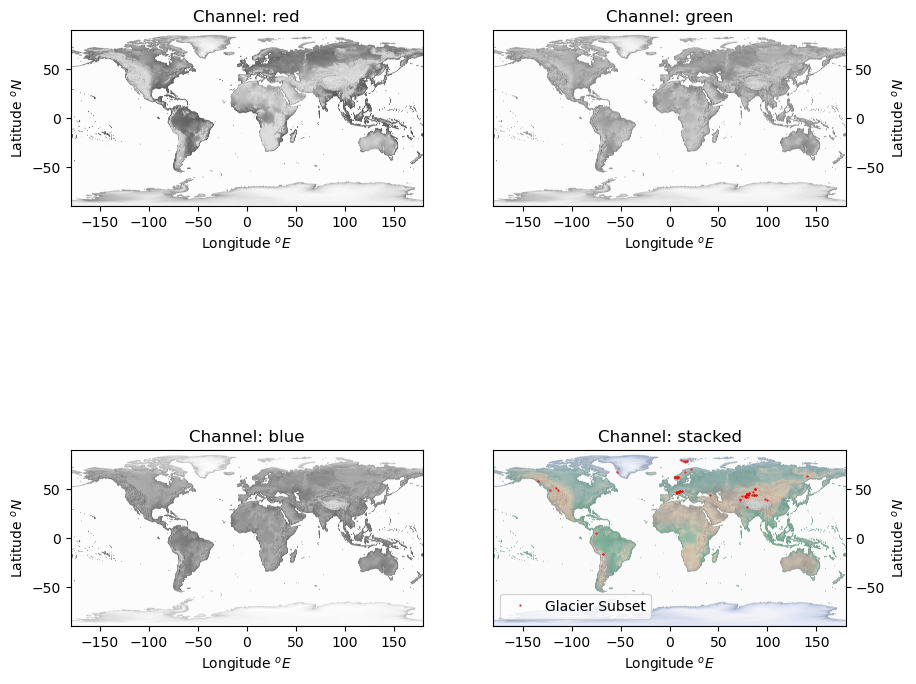

In [111]:
# solution
# Initialize new figure
fig = plt.figure(figsize=(10,10))
# Initialize subplot axes using GridSpec
gs = fig.add_gridspec(ncols=2,nrows=2)
# Use list comprehension to shorten this FOR loop
axs = [fig.add_subplot(gs[i_//2,i_%2]) for i_ in range(4)]
# Create dictionary of raster bands
chans = ['red','green','blue','stacked']
data_dict = dict(zip(chans,[red,green,blue,pix]))

# Iterate over raster bands to plot each channel + stacked
for i_,key in enumerate(data_dict.keys()):
    # Pull raster data
    rx = data_dict[key]
    # If input `rx` is single-channel, renders as greyscale - pix gets read as color 3-tuples per pixel
    axs[i_].imshow(rx,extent=bounds,cmap='Greys_r')
    # Label figure axes
    axs[i_].set_xlabel('Longitude $^oE$');
    axs[i_].set_ylabel('Latitude $^oN$');
    # If right-sided plots, shift ylabels to right side for clarity
    if i_%2 == 1:
        axs[i_].yaxis.set_label_position('right')
        axs[i_].yaxis.set_ticks_position('right')
    # Provide title
    axs[i_].set_title('Channel: %s'%(key))
# Option to print help documentation
# plt.imshow?

# Plot locations of glaciers in subset
axs[3].plot(df_glacier_subset['longitude'],df_glacier_subset['latitude'],'r.',ms=1,label='Glacier Subset')
axs[3].legend(loc='best')

## Option 2: Plotly

You may use plotly. For improved visibility, transform some of the data into log-spaced. You may add these transformed Series into the Pandas, and use them as input to plotly.

In [89]:

import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'vscode' # writes as standalone html, 
# pio.renderers.default = 'iframe' # writes files as standalone html, 
# pio.renderers.default = 'png' # writes files as standalone html, 
# try notebook, jupyterlab, png, vscode, iframe

In [132]:
# solution
# Use plotly.express `px` to plot data-frames with easier field syntax than my usual matplotlib approach (e.g., see above)
px.scatter(df_glacier_subset,x='mean_thickness',y='mean_slope',log_x=False,log_y=True)

## 3. Correlations between data parameters ( 5 points total)

Make plots to vizualise the correlation, or lack of, between all three data. Make at least three plots.

### a) Basic correlations using Matplotlib (2 points)

Make 3 plots using matplotlib to visualize slope, mean_thickness, and area. Use logscale to see the correlatons.

__Tips__: 
* Use the function ``scatter`` to plot the values of mean thickness, mean slope, area, and latitude. 
* use one of the dataframe columns as a color using the argument ``c``. You can also vary the ``colormap`` using the argument ``cmap``. Help on colormaps can be found here: https://matplotlib.org/stable/tutorials/colors/colormaps.html. Be mindful of Color-Vision Deficient readers and read *Crameri, F., Shephard, G.E. and Heron, P.J., 2020. The misuse of colour in science communication. Nature communications, 11(1), pp.1-10. https://doi.org/10.1038/s41467-020-19160-7* (find it on the class Gdrive). You can add a third "data" by choosing a marker color that scales with an other parameter. For instance, try coloring your marker with the ``LAT`` parameter to look at systematic latitudinal trends from the equator to the poles.
* Do not forget to adjust fontsize, figure size (at least 10,8), grid, labels with  of the features (example: km). ou may also explore the *logarithmic* correlations by mapping the axis from linear to logarithmic scale ``plt.xscale('log')``.

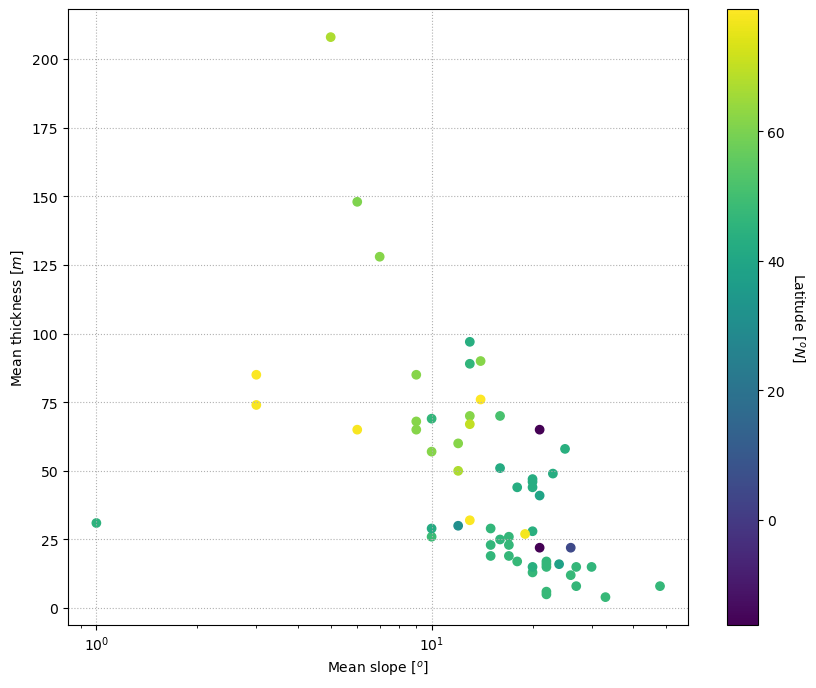

In [104]:
# Figure 1: Mean slope vs mean thickness
# solution
# Initialize plot & axis handle
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
# Plot data, passing colormap handle to `ch`
ch = ax.scatter(df_glacier_subset['mean_slope'],df_glacier_subset['mean_thickness'],\
                c=df_glacier_subset['latitude'],cmap='viridis')
# Add grid and axis labels
ax.grid(ls=':')
ax.set_xlabel('Mean slope [$^o$]')
ax.set_ylabel('Mean thickness [$m$]')
# Add colorbar and colorbar label
cbar = plt.colorbar(ch)
cbar.set_label('Latitude [$^oN$]',rotation=270,labelpad=15)
# Set x-axis scaling to log10
ax.set_xscale('log')

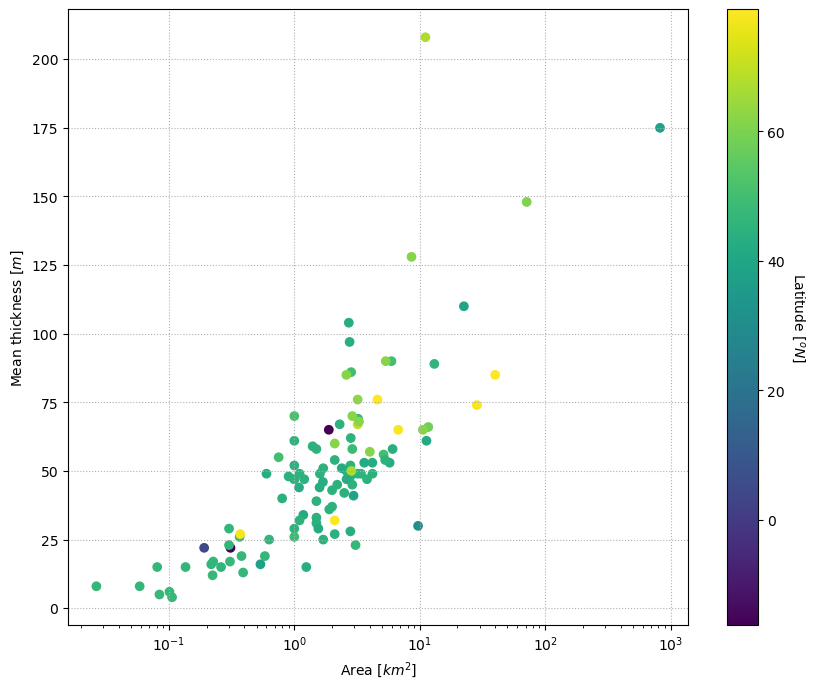

In [106]:
# Figure 2: area vs mean thickness
# solution
# Initialize plot & axis handle
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
# Plot data, passing colormap handle to `ch`
ch = ax.scatter(df_glacier_subset['area'],df_glacier_subset['mean_thickness'],\
                c=df_glacier_subset['latitude'],cmap='viridis')
# Add grid and axis labels
ax.grid(ls=':')
ax.set_xlabel('Area [$km^2$]')
ax.set_ylabel('Mean thickness [$m$]')
# Add colorbar and colorbar label
cbar = plt.colorbar(ch)
cbar.set_label('Latitude [$^oN$]',rotation=270,labelpad=15)
# Set x-axis scaling to log10
ax.set_xscale('log')

### b) 3D Scatter plot using Plotly (1 point)

Use the plotly ``scatter_3d`` plot. Make sure to change the pandas series for log scales.

In [128]:
# solution
import plotly as ply
ply.scatter_3d?

Object `ply.scatter_3d` not found.


### c) Pandas Correlation function (1 point)

You may use Pandas functionalities to explore correlation between data. Use the function ``corr`` on the dataframe and the matplotlib function ``matshow`` to plot a heatmap of the correlations

                mean_thickness  mean_slope      area
mean_thickness        1.000000   -0.411533  0.423154
mean_slope           -0.411533    1.000000 -0.103678
area                  0.423154   -0.103678  1.000000


[Text(0, 0, 'mean_thickness'), Text(0, 1, 'mean_slope'), Text(0, 2, 'area')]

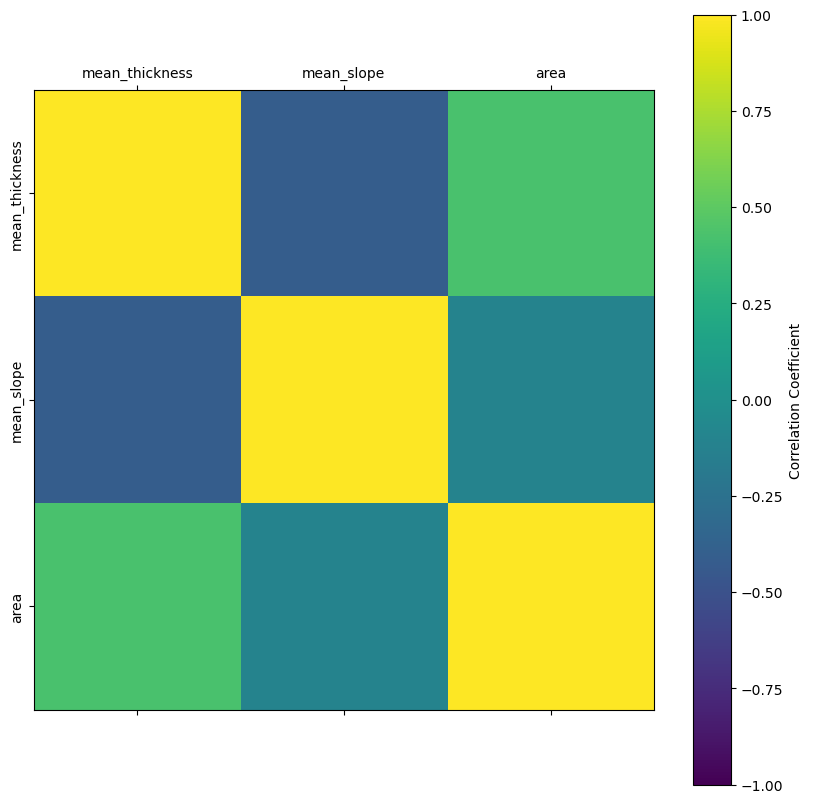

In [127]:
#solution
# Conduct correlation between desired data
df_glacier_subset_corr = df_glacier_subset[['mean_thickness','mean_slope','area']].corr()
# Print resultant correlation dataframe
print(df_glacier_subset_corr)
# Initialize figure & axis handles
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
# Plot correlation matrix & set color min/max to theoretical min/max (co)variance values
ch = ax.matshow(df_glacier_subset_corr,vmin=-1,vmax=1)
# Add colorbar
cbar = plt.colorbar(ch)
cbar.set_label('Correlation Coefficient')
# Re-label axis labels with field names
ax.set_xticks([0,1,2])
ax.set_xticklabels(df_glacier_subset_corr.columns,ha='center')
ax.set_yticks([0,1,2])
ax.set_yticklabels(df_glacier_subset_corr.index,rotation=90,va='center')

### f) Seaborn Plotting (1 point)

Seaborn is a great python package for basic data anlytics. See documentation [here](!https://seaborn.pydata.org/). You can visualize the data by plotting data features against each other and explore visually data correlations.

In [ ]:
#solution

In [ ]:
# solution
import seaborn as sns


Discuss the basic correlations among the data. Do these correction make sense when you think about the shapes of glaciers?

enter text below



## 4. Linear Regression (10 points total counted in the next section)
You found from basic data visualization that the three parameters ``mean_slope``, ``mean_thickness``, and ``area`` are correlated. It does make physical sense because a *steep* glaciers is likely to be in the high mountains regions, hanging on the mountain walls, and thus be constrained, and conversely, a flat glacier is either at its valley, ocean terminus or on ice sheets.

### a) Simple linear regression (2 points)
We will now perform a regression between the parameters (or their log!). Linear regressions are models that can be imported from scikit-learn. Log/exp functions in numpy as ``np.log()`` and ``np.exp()``.
Remember that a linear regression is finding $a$ and $b$ knowing both $x$ and the data $y$ in $y = Ax +b$. We want to predict ice thickness from a crude estimate of the glacier area.

__Tips__: 
a. make sure that the dimensions are correct and that there is no NaNs and zeros.
b. Make sure to inport the scikit learn linear regression function and the error metrics.

In [ ]:
# solution
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score



Make a plot of the data and the linear regression your performed

In [ ]:
# solution

**Briefly comment on the quality of your fit and a linear regression (1 point)**

The fit looks pretty good, except that there are outliers on the extreme low and high values of mean area.

### b) Leave One Out Cross Validation linear regression (1 point)


Perform the LOCCV on the ``area`` and ``thickness`` values. Predict the ``thickness`` value knowing a ``area`` value. Use material seen in class. Make a plot of your fit.

In [ ]:
from sklearn.model_selection import LeaveOneOut
# solution
loo = LeaveOneOut()

### c) Bootstrapping (1 point)

Perform the same analysis but using a bootstrapping technique. Output the mean and standard deviation of the slope. An illustration with a histogram  may help.

In [ ]:
from sklearn.utils import resample
# solution

k=100


### d) Predict the thickness of a glacier (2 points)

Let assume that you measure a glacier of area 10 km$^2$. Can you use your bootstrap regression framework to provide a distribution of possible values of the ice thickness ? Output the mean and standard deviation of the predicted ice thickness.

In [ ]:
# solution
k=100